# 1. Prediction Task
# 1.1 Modelling

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import GridSearchCV
import joblib
import numpy as np


In [2]:
# Load data
df_DataTrain = pd.read_csv('Data/DataTrain.csv')
print(df_DataTrain.head())

   engine_id  cycle   set1    set2    set3  sensor_val1  sensor_val2  \
0          1      1  100.0 -0.0007 -0.0004      9046.19       521.66   
1          1      2  100.0  0.0019 -0.0003      9044.07       522.28   
2          1      3  100.0 -0.0043  0.0003      9052.94       522.42   
3          1      4  100.0  0.0007  0.0000      9049.48       522.86   
4          1      5  100.0 -0.0019 -0.0002      9055.15       522.19   

   sensor_val3  sensor_val4  sensor_val5  ...  sensor_val12  sensor_val13  \
0      8138.62      1589.70       554.36  ...           392       2388.06   
1      8131.49      1591.82       553.75  ...           392       2388.04   
2      8133.23      1587.99       554.26  ...           390       2388.08   
3      8133.83      1582.79       554.45  ...           392       2388.11   
4      8133.80      1582.85       554.00  ...           393       2388.06   

   sensor_val14  sensor_val15  sensor_val16  sensor_val17  sensor_val18  \
0           1.3        641.82

In [3]:
print(df_DataTrain.columns)

Index(['engine_id', 'cycle', 'set1', 'set2', 'set3', 'sensor_val1',
       'sensor_val2', 'sensor_val3', 'sensor_val4', 'sensor_val5',
       'sensor_val6', 'sensor_val7', 'sensor_val8', 'sensor_val9',
       'sensor_val10', 'sensor_val11', 'sensor_val12', 'sensor_val13',
       'sensor_val14', 'sensor_val15', 'sensor_val16', 'sensor_val17',
       'sensor_val18', 'sensor_val19', 'sensor_val20', 'sensor_val21'],
      dtype='object')


In [4]:
print(df_DataTrain.describe())

          engine_id         cycle     set1          set2          set3  \
count  20631.000000  20631.000000  20631.0  20631.000000  20631.000000   
mean      51.506568    108.807862    100.0     -0.000009      0.000002   
std       29.227633     68.880990      0.0      0.002187      0.000293   
min        1.000000      1.000000    100.0     -0.008700     -0.000600   
25%       26.000000     52.000000    100.0     -0.001500     -0.000200   
50%       52.000000    104.000000    100.0      0.000000      0.000000   
75%       77.000000    156.000000    100.0      0.001500      0.000300   
max      100.000000    362.000000    100.0      0.008700      0.000600   

        sensor_val1   sensor_val2   sensor_val3   sensor_val4   sensor_val5  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.000000   
mean    9065.242941    521.413470   8143.752722   1590.523119    553.367711   
std       22.082880      0.737553     19.076176      6.131150      0.885092   
min     9021.7300

In [5]:
max_cycles = df_DataTrain.groupby('engine_id')['cycle'].max().reset_index()
max_cycles.rename(columns={'cycle': 'max_cycle'}, inplace=True)
df_DataTrain = df_DataTrain.merge(max_cycles, on='engine_id', how='left')
df_DataTrain['RUL'] = df_DataTrain['max_cycle'] - df_DataTrain['cycle']

In [6]:
df_DataTrain['RUL'] ,max_cycles, df_DataTrain

(0        191
 1        190
 2        189
 3        188
 4        187
         ... 
 20626      4
 20627      3
 20628      2
 20629      1
 20630      0
 Name: RUL, Length: 20631, dtype: int64,
     engine_id  max_cycle
 0           1        192
 1           2        287
 2           3        179
 3           4        189
 4           5        269
 ..        ...        ...
 95         96        336
 96         97        202
 97         98        156
 98         99        185
 99        100        200
 
 [100 rows x 2 columns],
        engine_id  cycle   set1    set2    set3  sensor_val1  sensor_val2  \
 0              1      1  100.0 -0.0007 -0.0004      9046.19       521.66   
 1              1      2  100.0  0.0019 -0.0003      9044.07       522.28   
 2              1      3  100.0 -0.0043  0.0003      9052.94       522.42   
 3              1      4  100.0  0.0007  0.0000      9049.48       522.86   
 4              1      5  100.0 -0.0019 -0.0002      9055.15       522.19   
 ...

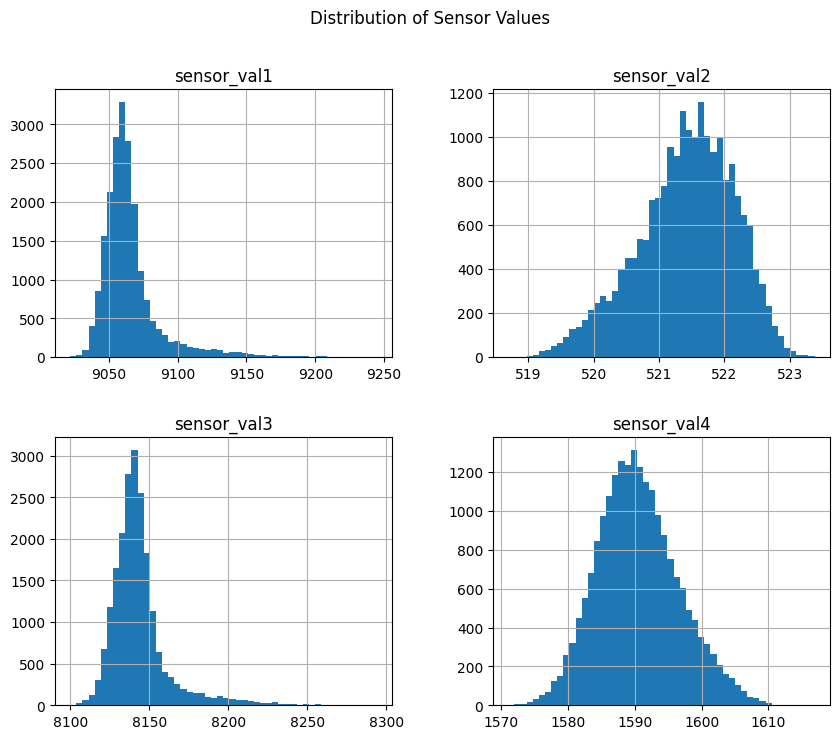

In [7]:
# import matplotlib.pyplot as plt

#histogram for each sensor val
df_DataTrain[['sensor_val1', 'sensor_val2', 'sensor_val3', 'sensor_val4']].hist(bins=50, figsize=(10, 8))
plt.suptitle('Distribution of Sensor Values')
plt.show()


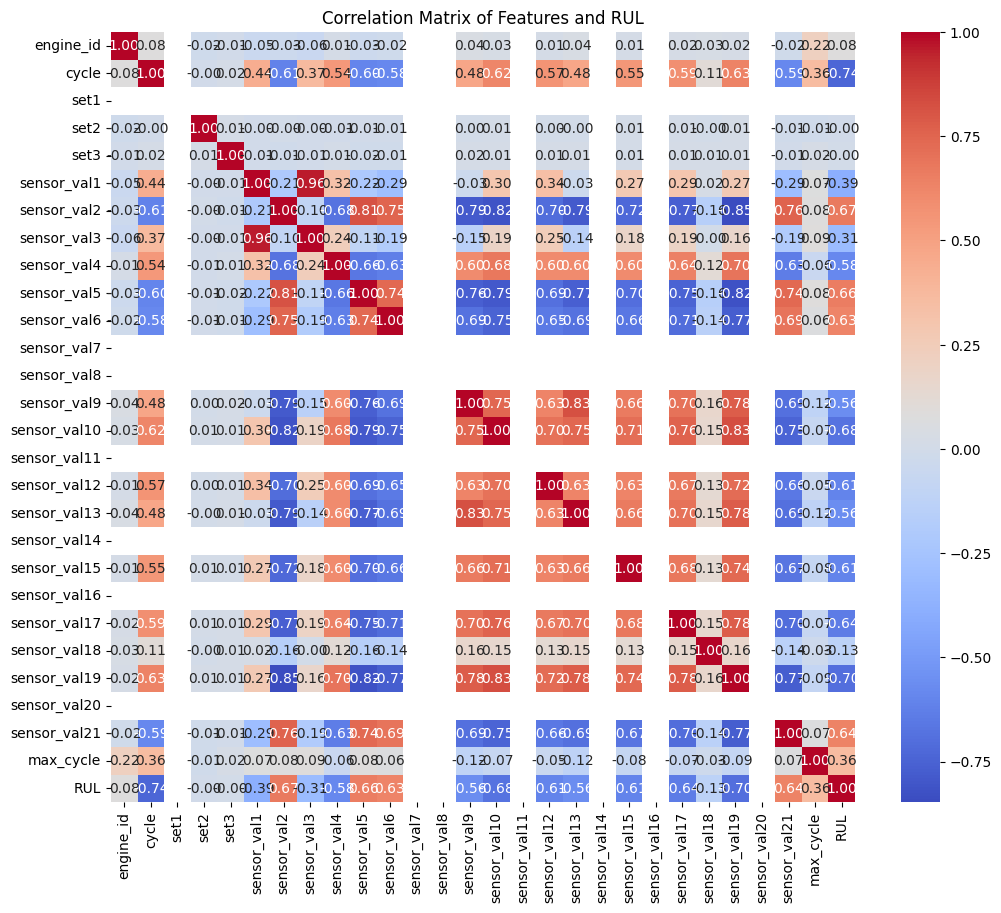

In [8]:
# import seaborn as sns

# Correlation matrix
correlation_matrix = df_DataTrain.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and RUL')
plt.show()


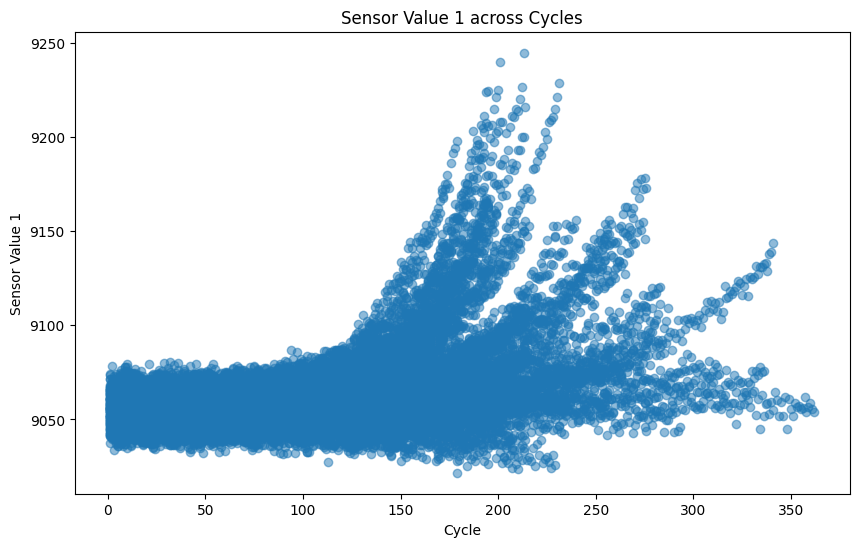

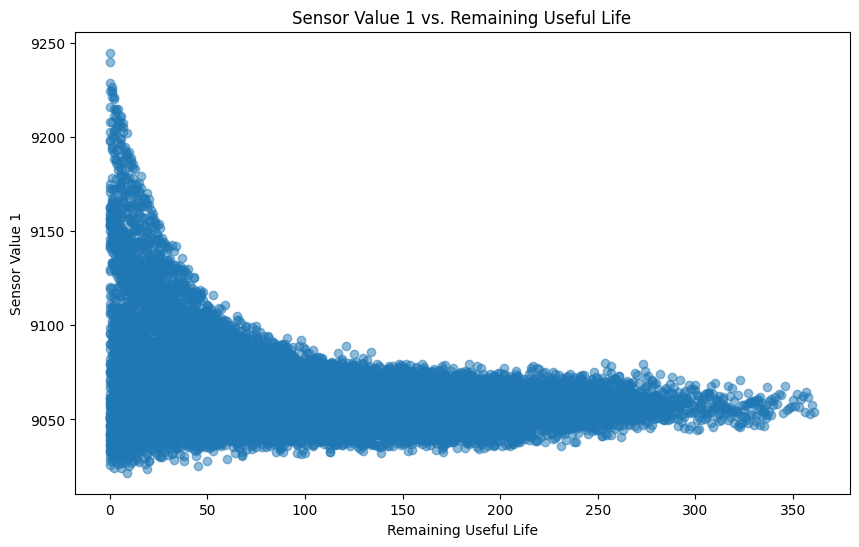

In [9]:
#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_DataTrain['cycle'], df_DataTrain['sensor_val1'], alpha=0.5)
plt.xlabel('Cycle')
plt.ylabel('Sensor Value 1')
plt.title('Sensor Value 1 across Cycles')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_DataTrain['RUL'], df_DataTrain['sensor_val1'], alpha=0.5)
plt.xlabel('Remaining Useful Life')
plt.ylabel('Sensor Value 1')
plt.title('Sensor Value 1 vs. Remaining Useful Life')
plt.show()


In [10]:
# Dropping colun not useful fro training
features = df_DataTrain.drop(columns=['RUL', 'engine_id', 'max_cycle' ])
target = df_DataTrain['RUL']

In [11]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [12]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred

#Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Absolute Error: 25.435071480494308
Root Mean Squared Error: 35.96044733350088
Mean Squared Error: 1293.1537724254908


/Users/vishalsehgal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor

# Get the feature importances
importances = model.feature_importances_
# CreateDataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
# Sort DataFrame by importance: descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print(feature_importance_df)

         Feature  Importance
0          cycle    0.539871
22  sensor_val19    0.141885
4    sensor_val1    0.042596
13  sensor_val10    0.039741
5    sensor_val2    0.031990
6    sensor_val3    0.024633
8    sensor_val5    0.023663
20  sensor_val17    0.021238
24  sensor_val21    0.020365
18  sensor_val15    0.019069
7    sensor_val4    0.019039
2           set2    0.015803
9    sensor_val6    0.015324
16  sensor_val13    0.014441
12   sensor_val9    0.014150
3           set3    0.009456
15  sensor_val12    0.006214
21  sensor_val18    0.000523
10   sensor_val7    0.000000
11   sensor_val8    0.000000
1           set1    0.000000
14  sensor_val11    0.000000
17  sensor_val14    0.000000
19  sensor_val16    0.000000
23  sensor_val20    0.000000


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Fit model with the best parameters
best_model = RandomForestRegressor(random_state=42, **best_params)
best_model.fit(X_train, y_train)


## 1.2 Prediction

In [ ]:
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Mean Squared Error:", mse)

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
# Save the model to disk
filename = 'finalized_model.sav'
joblib.dump(best_model, filename)

In [ ]:
# Load data
df_DataPredict = pd.read_csv('Data/DataSchedule.csv')
print(df_DataPredict.head())

In [ ]:
modele = joblib.load('finalized_model.sav')

df_features_predict = df_DataPredict.drop(columns=['engine_id'])

predicted_rul = modele.predict(df_features_predict)

predicted_rul_rounded = np.round(predicted_rul)

df_DataPredict['RUL'] = predicted_rul_rounded

print(df_DataPredict.head())

In [ ]:
df_DataPredict.to_csv('Data/DataSchedule-updated.csv', index=False)

print("CSV file has been updated and saved with new 'RUL' predictions.")

In [ ]:
dataconsul = pd.read_csv('Data/RUL_consultancy_predictions_A3.csv', delimiter=';')

dataconsul.columns = ['RUL', 'id']

dataconsul['RUL'] = dataconsul['RUL'].astype(int)

dataconsul['id'] = dataconsul['id'].astype(int)

dataconsul.rename(columns={'id': 'engine_id'}, inplace=True)


In [ ]:
idx = df_DataPredict.groupby('engine_id')['cycle'].idxmax()

resultpredicted_df = df_DataPredict.loc[idx, ['engine_id', 'RUL']]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set()

# Create a figure with specified size
plt.figure(figsize=(12, 6))

# Histogram for result_df
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(resultpredicted_df['RUL'], kde=True, color='blue', label='Data Predicted')
plt.title('Histogram of RUL for Data Predicted')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.legend()

# Histogram for data2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(dataconsul['RUL'], kde=True, color='green', label='Data Consul')
plt.title('Histogram of RUL for DataConsul')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_ind

# Conduct the t-test
t_stat, p_value = ttest_ind(resultpredicted_df['RUL'], dataconsul['RUL'], equal_var=False)  # equal_var=False for Welch's t-test

# Print the results
print("T-test results:")
print("T-statistic:", t_stat)
print("P-value:", p_value)

# 2. Optimization Task

## 2.1 Genetic Algorithm 

In [ ]:
import random 
from deap import base, creator, tools, algorithms 
import numpy as np

In [ ]:
# Declare constants

# Maintenance days 

num_days = 30
num_engines = 100 
team_a_days = [4] * 20 + [3] * 35 + [2] * 25 + [8] * 20 
team_b_days = [days + 1 for days in team_a_days[:25]] + \
              [days + 2 for days in team_a_days[25:70]] + \
              [days + 1 for days in team_a_days[70:]]


# Penalty costs

cost_factors = [4] * 20 + [3] * 10 + [2] * 15 + [5] * 35 + [6] * 20

In [ ]:
# Loading RULs

RULs = df_DataPredict['RUL'].values

In [ ]:
# Define Individuals

# The three factors that define an individual are: engine_id, team type and start day of the maintenance

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [ ]:
def create_individual():
    individual = creator.Individual()
    teams = {'A': [1, 2], 'B': [1, 2]}  # Two teams for A and B
    last_day = {('A', 1): 0, ('A', 2): 0, ('B', 1): 0, ('B', 2): 0}  # Track last working day for each team

    engines = list(range(1, num_engines + 1))
    random.shuffle(engines)  # Shuffle engines to randomize the assignment order

    for engine_id in engines:
        team_type = random.choice(['A', 'B'])
        team_number = random.choice(teams[team_type])
        team_key = (team_type, team_number)

        # Find the earliest possible start day that doesn't break the num_days rule
        team_days = team_a_days[engine_id - 1] if team_type == 'A' else team_b_days[engine_id - 1]
        min_start_day = last_day[team_key] + 1
        max_start_day = num_days - team_days

        if min_start_day <= max_start_day:
            start_day = min_start_day  # Start as soon as the team is available
        else:
            continue  # Skip if no valid start day is possible

        end_day = start_day + team_days - 1
        individual.append((engine_id, team_type, team_number, start_day, end_day))
        last_day[team_key] = end_day  # Update the last day this team is busy until

    return individual

In [ ]:
def mutate(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            engine_id, team_type, team_number, start_day, end_day = individual[i]
            max_start_day = num_days - (team_a_days[engine_id - 1] if team_type == 'A' else team_b_days[engine_id - 1])
            new_start_day = random.randint(1, max_start_day)
            new_end_day = new_start_day + (team_a_days[engine_id - 1] if team_type == 'A' else team_b_days[engine_id - 1])
            individual[i] = (engine_id, team_type, team_number, new_start_day, new_end_day)
    return individual,



def crossover(ind_a, ind_b):
    half = len(ind_a) // 2
    child1 = ind_a[:half] + [item for item in ind_b if item[0] not in [x[0] for x in ind_a[:half]]]
    child2 = ind_b[:half] + [item for item in ind_a if item[0] not in [x[0] for x in ind_b[:half]]]
    return creator.Individual(child1), creator.Individual(child2)

In [ ]:
def evaluate(individual):
    total_penalty = 0
    last_maintenance_day = {engine_id: 0 for engine_id in range(1, num_engines + 1)}

    # Update maintenance periods and calculate penalties for maintained engines
    for engine_id, team_type, team_number, start_day, end_day in individual:
        due_date = int(RULs[engine_id - 1])  # Ensure due_date is an integer
        if end_day < due_date:
            # No penalty if maintenance ends before the due date
            last_maintenance_day[engine_id] = end_day
        else:
            # Calculate penalty from the due date to the last maintenance day
            for day in range(due_date, end_day + 1):
                daily_penalty = min(250, cost_factors[engine_id - 1] * ((day - due_date) ** 2))
                total_penalty += daily_penalty
            last_maintenance_day[engine_id] = end_day

    # Calculate penalties for engines not maintained or maintained but finished before their RUL
    for engine_id, last_day in last_maintenance_day.items():
        due_date = int(RULs[engine_id - 1])  # Convert to integer here as well
        if last_day < due_date:
            # If no maintenance or maintenance ends before the due date, calculate penalty from due date to end of period
            for day in range(due_date, num_days + 1):
                daily_penalty = min(250, cost_factors[engine_id - 1] * ((day - due_date) ** 2))
                total_penalty += daily_penalty

    return (total_penalty,)



def get_schedule_details(individual):
    schedule_details = []
    last_day = {('A', 1): 0, ('A', 2): 0, ('B', 1): 0, ('B', 2): 0}  # Adjusted for two teams per type

    for engine_id, team_type, team_number, start_day, end_day in sorted(individual, key=lambda x: x[3]):  # x[3] is start_day
        team_key = (team_type, team_number)
        
        # You might want to check here if any maintenance overlaps occur and handle them
        if start_day < last_day[team_key]:
            continue  # Skip or handle this case as needed

        last_day[team_key] = end_day  # Update the last day this team is busy until

        # Assume due_date is calculated or retrieved similarly to your setup
        due_date = RULs[engine_id - 1]
        delay = max(0, end_day - due_date)
        penalty = min(250, cost_factors[engine_id - 1] * (delay ** 2))

        schedule_details.append((engine_id, team_type, start_day, end_day, cost_factors[engine_id - 1], penalty))

    return schedule_details


toolbox = base.Toolbox()
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
def main():
    random.seed(64)
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, stats=stats, halloffame=hof, verbose=True)

    best_individual = hof[0]
    best_fitness = evaluate(best_individual)  # Only fetching the fitness
    details = get_schedule_details(best_individual)  # Get details separately

    print("Best Fitness:", best_fitness[0])
    print("Best Schedule Details:")
    total_penalty = 0
    for d in details:
        print(f"Engine {d[0]}, Team {d[1]}, Start {d[2]}, End {d[3]}, Cost/Engine {d[4]}, Penalty {d[5]}")
        total_penalty += d[5]
    print(f"Total Penalty Cost: {total_penalty}")

    return pop, log, hof

if __name__ == "__main__":
    main()

## 2.2 Optimization

In [ ]:
import time

def run_algorithm():
    """Set up and run the GA, returning the best individual's fitness."""
    random.seed(64)
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # Run the algorithm with time limit
    start_time = time.time()
    while time.time() - start_time < 20:  # 300 seconds = 5 minutes
        pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof, verbose=False)
        if time.time() - start_time >= 20:
            break
    
    return hof[0].fitness.values[0]

# Run the algorithm 30 times
num_runs = 30
best_fitnesses = []

for _ in range(num_runs):
    best_fitness = run_algorithm()
    best_fitnesses.append(best_fitness)

# Compute the average of the best fitness values
average_best_fitness = np.mean(best_fitnesses)

# Plotting the average best fitness
plt.figure(figsize=(10, 5))
plt.plot(range(num_runs), best_fitnesses, label='Best Fitness per Run')
plt.axhline(y=average_best_fitness, color='r', linestyle='-', label=f'Average Best Fitness: {average_best_fitness:.2f}')
plt.xlabel('Run Number')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Across 30 Runs')
plt.legend()
plt.show()

## 2.3 Comparison

In [ ]:
# Loading RULs

RULsconsul = dataconsul['RUL'].values

In [ ]:
import time

def run_algorithm(RULs, num_runs):
    """Run the GA multiple times with specified RULs, respecting a 5-minute limit per run."""
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    # Assuming other necessary toolbox setup here...

    best_fitnesses = []

    for _ in range(num_runs):
        pop = toolbox.population(n=50)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", np.min)
        stats.register("avg", np.mean)

        start_time = time.time()
        while time.time() - start_time < 20:  # 300 seconds = 5 minutes
            pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof, verbose=False)
            if time.time() - start_time >= 20:
                break

        best_fitnesses.append(hof[0].fitness.values[0])

    return best_fitnesses

# Run the algorithm multiple times for both sets of RULs
num_runs = 30
fitness_results_RULs1 = run_algorithm(RULsconsul, num_runs)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(range(num_runs), fitness_results_RULs1, marker='o', linestyle='-', color='blue', label='RULs1')
plt.title('Comparison of Genetic Algorithm Performance with Different RUL Sets')
plt.xlabel('Run Number')
plt.ylabel('Best Fitness')
plt.legend()
plt.grid(True)
plt.show()